### Import data

In [1]:
import pandas as pd
import numpy as np

# Change the path below to the actual local path for everything to work 
# (or better yet, just create a Datasets folder on your pwd and drop it there)
df = pd.read_csv('./academic_performance.csv', header=0)

In [2]:
df['Class'].value_counts().index.tolist()[-1]

'L'

### Correct typos

In [3]:
newcols = df.columns.values
newcols[0] = "Gender"
newcols[1] = "Nationality"
newcols[2] = "PlaceOfBirth"
newcols[9] = "RaisedHands"
newcols[10] = "VisitedResources"
newcols[14] = "ParentSchoolSatisfaction"
df.columns = newcols

# Discard PlaceOfBirth, as it is redundant with Nationality
df = df.drop(["PlaceOfBirth"], axis = 1)

In [4]:
df["Nationality"] = df['Nationality'].str.replace("KW", "Kuwait")
df["Nationality"] = df['Nationality'].str.replace("lebanon", "Lebanon")
df["Nationality"] = df['Nationality'].str.replace("venzuela", "Venezuela")
df["Nationality"] = df['Nationality'].str.replace("Tunis", "Tunisia")
df["Nationality"] = df['Nationality'].str.replace("Lybia", "Libya")
df["Nationality"] = df['Nationality'].str.replace("lebanon", "Lebanon")

In [5]:
df["StageID"] = df["StageID"].str.replace("lowerlevel", "LowerLevel")
df.Gender = np.where(df.Gender == "M", "Male", "Female")
df.Semester = np.where(df.Semester == "F", "First", "Second")
df.SectionID = "section_" + df.SectionID
df["Relation"] = df["Relation"].str.replace("Mum", "Mother")

In [7]:
# Copy with names for EDA
df.to_csv('./academic_performance_clean.csv', index=False)

### Change Gender, StageID, GradeID, Semester, Relation, ParentAnswering, ParentSchool, Class, StudentAbsence to numerical values

Codes:

- Gender: 0 Female, 1 Male
- StageID: 0 Lower, 1 Middle, 2 High
- GradeID: 0 - 11
- Semester: 0 First, 1 Second
- Relation: 0 Mother, 1 Father
- ParentAnswering: 0 No, 1 Yes
- ParentSchool: 0 Bad, 1 Good
- Class: 0 L, 1 M, 2 H
- StudentAbsence: 0 Under-7, 1 Above-7

In [8]:
df.Gender = np.where(df.Gender == "Male", 1, 0)
df.StageID = np.where(df.StageID == "LowerLevel", 0,
                      np.where(df.StageID == "MiddleSchool", 1, 2))
df.GradeID = df.GradeID.str[2:].astype(np.int64) - 1
df.Semester = np.where(df.Semester == "First", 0, 1)
df.Relation = np.where(df.Relation == "Father", 1, 0)
df.ParentAnsweringSurvey = np.where(df.ParentAnsweringSurvey == "No", 0, 1)
df.ParentSchoolSatisfaction = np.where(df.ParentSchoolSatisfaction == "Bad", 0, 1)
df.Class = np.where(df.Class == "L", 0,
                    np.where(df.Class == "M", 1, 2))
df.StudentAbsenceDays = np.where(df.StudentAbsenceDays == "Under-7", 0, 1)

### Turn Nationality, SectionID, Topic into dummy variables

In [9]:
col = ["Nationality", "SectionID", "Topic"]

for c in col:
    dummies = []
    dummies.append(pd.get_dummies(df[c]))
    df_dummies = pd.concat(dummies, axis = 1)
    df = pd.concat((df, df_dummies), axis = 1)
    df = df.drop([c], axis = 1)

In [11]:
df.to_csv('./academic_onehot.csv', index=False)

## Prepare for ML / Hyper-param tuning

In [12]:
import pandas as pd
import numpy as np

# Get balancing feature to end column
df = pd.read_csv('./academic_onehot.csv', header=0)

# Uncomment the feature to rebalance
rebal_feat = 'Class'
#rebal_feat = 'Gender'

# Uncomment the predicting feature
pred_feat = 'Class'

# Put rebalancing feat last for easier manipulation
df = df[[c for c in df if c not in [rebal_feat]] + [rebal_feat]]

In [13]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split data in train / tet
train, test = train_test_split(df, test_size=0.10, random_state=42)

# Generate balanced set by undersampling males to match the number of females
num_minority = train[rebal_feat].value_counts()[train[rebal_feat].value_counts().index.tolist()[-1]]

train_under = train[train[rebal_feat] ==
                    train[rebal_feat].value_counts().index[-1]]
for i in range(train[rebal_feat].nunique() - 1):
    train_sample = train[train[rebal_feat] ==
                         train[rebal_feat].value_counts().index[i]].sample(num_minority)
    train_under = pd.concat([train_under, train_sample])

#train_majority_sample = train[train[rebal_feat] == 1].sample(num_minority)
#train_under = train[train[rebal_feat] == 0]
#train_under = pd.concat([train_under, train_majority_sample])
    
# Unbalanced train set
X = train.drop([pred_feat], axis=1).values
y = train[pred_feat].values

# Balanced train set using SMOTE
X_pre = train.drop([rebal_feat], axis=1).values
y_pre = train[rebal_feat].values
X_sm, y_sm = SMOTE().fit_sample(X_pre, y_pre)
y_sm = y_sm.reshape((y_sm.shape[0], 1))
X_sm = np.append(X_sm, y_sm, axis=1)
smDF = pd.DataFrame(X_sm, columns=df.columns.tolist())
X_smote = smDF.drop([pred_feat], axis=1).values
y_smote = smDF[pred_feat].values.astype(int)
    
# Balanced train set using undersampling
X_under = train_under.drop([pred_feat], axis=1).values
y_under = train_under[pred_feat].values

# Test sets
X_test = test.drop([pred_feat], axis=1).values
y_test = test[pred_feat].values

Using TensorFlow backend.
/Users/npm65/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/npm65/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/npm65/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/npm65/miniconda3/lib/python3.6/site-packages/t

In [14]:
train.Class.value_counts()

1    188
2    129
0    115
Name: Class, dtype: int64

In [15]:
train_under.Class.value_counts()

2    115
1    115
0    115
Name: Class, dtype: int64

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

bbase_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
bbase_model.fit(X, y)
evaluate(bbase_model, X_test, y_test)

Model Performance
Accuracy = 0.75%.


0.75

In [15]:
sbase_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
sbase_model.fit(X_smote, y_smote)
evaluate(sbase_model, X_test, y_test)

Model Performance
Accuracy = 0.71%.


0.7083333333333334

In [16]:
ubase_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
ubase_model.fit(X_under, y_under)
evaluate(ubase_model, X_test, y_test)

Model Performance
Accuracy = 0.73%.


0.7291666666666666

In [17]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': range(20, 520, 20)
}

# Instantiate the grid search model
bgrid_search = sgrid_search = ugrid_search = GridSearchCV(estimator = rf, param_grid=param_grid,
                                                          cv=3, n_jobs=-1, verbose=1)

In [18]:
bgrid_search.fit(X, y)
bgrid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   10.1s finished


{'n_estimators': 380}

In [19]:
bgrid_accuracy = evaluate(bgrid_search, X_test, y_test)

Model Performance
Accuracy = 0.81%.


In [20]:
sgrid_search.fit(X_smote, y_smote)
sgrid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   10.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.3s finished


{'n_estimators': 120}

In [21]:
sgrid_accuracy = evaluate(sgrid_search, X_test, y_test)

Model Performance
Accuracy = 0.77%.


In [22]:
ugrid_search.fit(X_under, y_under)
ugrid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.0s finished


{'n_estimators': 200}

In [23]:
ugrid_accuracy = evaluate(ugrid_search, X_test, y_test)

Model Performance
Accuracy = 0.77%.


### Our num_estimators will be 340 for base, 280 for smote and 240 for under (Gender balance) and 380, 80, 80 for Class balance

In [102]:
est_nums = {'Gender': {'base': 340, 'smote': 280, 'under': 240},
            'Class': {'base': 380, 'smote': 120, 'under': 200}}

n_rows = df.shape[0]

In [110]:
# Split data in 480 train-test sets (leave one out)

Xs = []
ys = []
Xs_smote = []
ys_smote = []
Xs_under = []
ys_under = []
rXs = []
rys = []

for i in range(n_rows):
    train_df = df.drop(df.index[i])
    test_df = df.iloc[[i]]

    # Generate balanced set by undersampling majority classes to match the minority class
    num_minority = train[rebal_feat].value_counts()[train[rebal_feat].value_counts().index.tolist()[-1]]

    train_under = train[train[rebal_feat] ==
                        train[rebal_feat].value_counts().index[-1]]
    for i in range(train[rebal_feat].nunique() - 1):
        train_sample = train[train[rebal_feat] ==
                             train[rebal_feat].value_counts().index[i]].sample(num_minority)
        train_under = pd.concat([train_under, train_sample])

    # Unbalanced train set
    X = train_df.drop([pred_feat], axis=1).values
    y = train_df[pred_feat].values
    
    # Balanced train set using SMOTE
    X_pre = train_df.drop([rebal_feat], axis=1).values
    y_pre = train_df[rebal_feat].values
    X_sm, y_sm = SMOTE().fit_sample(X_pre, y_pre)
    y_sm = y_sm.reshape((y_sm.shape[0], 1))
    X_sm = np.append(X_sm, y_sm, axis=1)
    smDF = pd.DataFrame(X_sm, columns=df.columns.tolist())
    X_smote = smDF.drop([pred_feat], axis=1).values
    y_smote = smDF[pred_feat].values.astype(int)

    # Balanced train set using undersampling
    X_under = train_under.drop([pred_feat], axis=1).values
    y_under = train_under[pred_feat].values

    # Reserved test set
    rX = test_df.drop([pred_feat], axis=1).values
    ry = test_df[pred_feat].values

    # Build arrays with all different
    Xs.append(X)
    ys.append(y)
    Xs_smote.append(X_smote)
    ys_smote.append(y_smote)
    Xs_under.append(X_under)
    ys_under.append(y_under)
    rXs.append(rX)
    rys.append(ry)

## Get predictions

In [111]:
from sklearn.ensemble import RandomForestClassifier as rf

rf_preds = pd.DataFrame(np.zeros((n_rows, 7)))
rf_preds.columns = ['base', 'smote', 'under', 'real',
                    'base_p', 'smote_p', 'under_p']

for i in range(n_rows):
    X = Xs[i]
    y = ys[i]
    X_smote = Xs_smote[i]
    y_smote = ys_smote[i]
    X_under = Xs_under[i]
    y_under = ys_under[i]
    rX = rXs[i]
    
    rf_base = rf(n_estimators=est_nums[rebal_feat]['base'])
    rf_base.fit(X, y)
    rf_smote = rf(n_estimators=est_nums[rebal_feat]['smote'])
    rf_smote.fit(X_smote, y_smote)
    rf_under = rf(n_estimators=est_nums[rebal_feat]['under'])
    rf_under.fit(X_under, y_under)
    
    rf_preds.base.iloc[i] = rf_base.predict(rX)
    rf_preds.smote.iloc[i] = rf_smote.predict(rX)
    rf_preds.under.iloc[i] = rf_under.predict(rX)
    rf_preds.real.iloc[i] = df[pred_feat].iloc[i]
    rf_preds.base_p.iloc[i] = np.max(rf_base.predict_proba(rX))
    rf_preds.smote_p.iloc[i] = np.max(rf_smote.predict_proba(rX))
    rf_preds.under_p.iloc[i] = np.max(rf_under.predict_proba(rX))

In [112]:
strats = ['smote', 'under']

for s in strats:
    rf_preds['cat_' + s] = [0 if (p == q and p == r) else
                            1 if (p == r or  q == r) else
                            2 if (p == q and p != r) else
                            3 for (p, q, r) in zip(rf_preds.base,
                                                   rf_preds[s],
                                                   rf_preds.real)]

In [113]:
rf_preds['abs_smote'] = abs(rf_preds['base'] - rf_preds['smote'])
rf_preds['abs_under'] = abs(rf_preds['base'] - rf_preds['under'])

In [116]:
rf_preds.cat_smote.value_counts()

0    372
2     80
1     27
3      1
Name: cat_smote, dtype: int64

In [117]:
rf_preds.to_csv('../Datasets/academic_rf_predictions_'
                + rebal_feat + '.csv', index=False)

In [118]:
# TODO: change originalClean to better name!
df = pd.read_csv('../Datasets/originalClean.csv', header=0)
dfplus = pd.read_csv('../Datasets/academic_onehot.csv', header=0)
dfml = dfplus
rf_preds = pd.read_csv('../Datasets/academic_rf_predictions_'
                       + rebal_feat + '.csv', header=0)

In [119]:
cols = ['base', 'smote', 'under',
        'base_p', 'smote_p', 'under_p',
        'cat_smote', 'cat_under',
        'abs_smote', 'abs_under']

for d in [df, dfplus]:
    for c in cols:
        d[c] = rf_preds[c]
    
df.to_csv('../Datasets/academic_interp_all_'
          + rebal_feat + '.csv', index=False)
dfplus.to_csv('../Datasets/academic_onehot_all_'
              + rebal_feat + '.csv', index=False)

In [120]:
df.head()

,Gender,Nationality,StageID,GradeID,SectionID,Topic,Semester,Relation,RaisedHands,VisitedResources,...,base,smote,under,base_p,smote_p,under_p,cat_smote,cat_under,abs_smote,abs_under
0,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,15,16,...,1.0,1.0,1.0,0.634211,0.6250,0.4250,0,0,0.0,0.0
1,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,20,20,...,1.0,1.0,1.0,0.802632,0.7500,0.8625,0,0,0.0,0.0
2,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,10,7,...,0.0,0.0,0.0,0.950000,0.9750,0.9875,0,0,0.0,0.0
3,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,30,25,...,0.0,0.0,0.0,0.805263,0.8125,0.9000,0,0,0.0,0.0
4,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,40,50,...,0.0,0.0,1.0,0.563158,0.6875,0.7500,2,1,0.0,1.0


## Volatility Analysis

In [2]:
import pandas as pd
import numpy as np
#rebal_feat = 'Class'
rebal_feat = 'Gender'

df = pd.read_csv('../Datasets/academic_interp_all_' + rebal_feat + '.csv', header=0)
dfplus = pd.read_csv('../Datasets/academic_onehot_all_' + rebal_feat + '.csv', header=0)
dfml = pd.read_csv('../Datasets/academic_onehot.csv', header=0)

### One-way Kruskal-Wallis analysis of prediction probability variance by volatility category

In [219]:
print('SMOTE Standard Deviations\n')

for i in range(3):
    print(str(i)
          + ': '
          + str(np.round(np.std(df.smote_p[df.cat_smote == i]), 2)))

SMOTE Standard Deviations

0: 0.13
1: 0.04
2: 0.12


In [220]:
print('Under Standard Deviations\n')

for i in range(3):
    print(str(i)
          + ': '
          + str(np.round(np.std(df.under_p[df.cat_under == i]), 2)))

Under Standard Deviations

0: 0.13
1: 0.07
2: 0.12


In [221]:
import scipy.stats as stats

smote_zero = df.smote_p[df.cat_smote == 0]
smote_one = df.smote_p[df.cat_smote == 1]
smote_two = df.smote_p[df.cat_smote == 2]

stats.kruskal(smote_zero, smote_one, smote_two).pvalue

6.877181988775531e-20

In [222]:
under_zero = df.under_p[df.cat_under == 0]
under_one = df.under_p[df.cat_under == 1]
under_two = df.under_p[df.cat_under == 2]

stats.kruskal(under_zero, under_one, under_two).pvalue

1.2024341286332645e-18

In [223]:
smote_nonvol = pd.concat([smote_zero, smote_two])
smote_vol = smote_one

stats.kruskal(smote_nonvol, smote_vol).pvalue

1.728018576686655e-12

In [224]:
under_nonvol = pd.concat([under_zero, under_two])
under_vol = under_one

stats.kruskal(under_nonvol, under_vol).pvalue

2.7344223992002126e-13

In [225]:
stats.kruskal(smote_zero, smote_two).pvalue

2.103232374467639e-10

In [226]:
stats.kruskal(under_zero, under_two).pvalue

3.607931777293843e-08

In [227]:
stats.kruskal(smote_one, smote_two).pvalue

2.144086004255859e-06

In [228]:
stats.kruskal(under_one, under_two).pvalue

0.0003359575484254975

## Volatility Counts

In [3]:
df.cat_smote.value_counts(normalize=True).round(2)

0    0.79
2    0.16
1    0.05
Name: cat_smote, dtype: float64

In [4]:
df.cat_under.value_counts(normalize=True).round(2)

0    0.76
2    0.15
1    0.09
3    0.00
Name: cat_under, dtype: float64

In [231]:
df.abs_smote.value_counts()

0.0    455
1.0     25
Name: abs_smote, dtype: int64

In [232]:
df.abs_under.value_counts()

0.0    435
1.0     45
Name: abs_under, dtype: int64

## Kappa Agreements

In [233]:
agree = len(df[df.base == df.smote])
total = len(df)
p0 = agree / total

p_0 = ((len(df[df.base == 0.0]) / total) 
       * (len(df[df.smote == 0.0]) / total))
p_1 = ((len(df[df.base == 1.0]) / total) 
       * (len(df[df.smote == 1.0]) / total))
    
p_e = p_0 + p_1

kappa_smote = (p0 - p_e) / (1 - p_e)

print(kappa_smote)

0.9271181293653201


In [234]:
agree = len(df[df.base == df.under])
total = len(df)
p0 = agree / total

p_0 = ((len(df[df.base == 0.0]) / total) 
       * (len(df[df.under == 0.0]) / total))
p_1 = ((len(df[df.base == 1.0]) / total) 
       * (len(df[df.under == 1.0]) / total))
    
p_e = p_0 + p_1

kappa_under = (p0 - p_e) / (1 - p_e)

print(kappa_under)

0.8691606900562124


In [235]:
agree = len(df[df.smote == df.under])
total = len(df)
p0 = agree / total

p_0 = ((len(df[df.smote == 0.0]) / total) 
       * (len(df[df.under == 0.0]) / total))
p_1 = ((len(df[df.smote == 1.0]) / total) 
       * (len(df[df.under == 1.0]) / total))
    
p_e = p_0 + p_1

kappa_smote_under = (p0 - p_e) / (1 - p_e)

print(kappa_smote_under)

0.8531139835487661


## Accuracies

In [236]:
from sklearn.metrics import accuracy_score

accuracy_score(dfml["Class"], df["base"])

0.8104166666666667

In [237]:
accuracy_score(dfml["Class"], df["smote"])

0.8125

In [238]:
accuracy_score(dfml["Class"], df["under"])

0.7979166666666667

## Contingency tables for volatility vs class, gender

In [239]:
smote_class = pd.crosstab(dfml['Class'],
                          df['cat_smote'],
                          rownames=['Class'],
                          colnames=['cat_smote'],
                          normalize='index').round(2)
smote_class

cat_smote,0,1,2
Class,,,
0,0.87,0.02,0.12
1,0.78,0.07,0.15
2,0.72,0.06,0.22


In [240]:
under_class = pd.crosstab(dfml['Class'],
                          df['cat_under'],
                          rownames=['Class'],
                          colnames=['cat_under'],
                          normalize='index').round(2)
under_class

cat_under,0,1,2,3
Class,,,,
0,0.83,0.06,0.10,0.01
1,0.76,0.09,0.15,0.00
2,0.69,0.13,0.18,0.00


In [241]:
smote_gender = pd.crosstab(df['Gender'],
                           df['cat_smote'],
                           rownames=['Gender'],
                           colnames=['cat_smote'],
                           normalize='index').round(2)
smote_gender

cat_smote,0,1,2
Gender,,,
Female,0.77,0.07,0.15
Male,0.79,0.04,0.17


In [242]:
under_gender = pd.crosstab(df['Gender'],
                           df['cat_under'],
                           rownames=['Gender'],
                           colnames=['cat_under'],
                           normalize='index').round(2)
under_gender

cat_under,0,1,2,3
Gender,,,,
Female,0.78,0.03,0.18,0.0
Male,0.74,0.12,0.13,0.0


## Decision tree for categorical volatility

In [25]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC as svm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

df = pd.read_csv('../Datasets/academic_interp_all_Class.csv', header=0)
dfml = pd.read_csv('../Datasets/academic_onehot.csv', header=0)
X = dfml.values
n_rows = dfml.shape[0]
y_smote = df['cat_smote'].values
y_under = df['cat_under'].values

model_names = ['DT', 'RF', 'KNN', 'SVM']

[smote_dt_preds, under_dt_preds,
 smote_rf_preds, under_rf_preds,
 smote_knn_preds, under_knn_preds,
 smote_svm_preds, under_svm_preds] = np.zeros((8, n_rows))

smote_dt = under_dt = dt(max_depth=4, min_samples_split=10)
smote_rf = under_rf = rf()
smote_knn = under_knn = knn()
smote_svm = under_svm = svm()

smote_models = [smote_dt, smote_rf, smote_knn, smote_svm]
under_models = [under_dt, under_rf, under_knn, under_svm]
models = smote_models + under_models

smote_preds = [smote_dt_preds, smote_rf_preds, smote_knn_preds, smote_svm_preds]
under_preds = [under_dt_preds, under_rf_preds, under_knn_preds, under_svm_preds]
preds = smote_preds + under_preds

loo =LeaveOneOut()
for train, test in loo.split(X):
    
    for m in smote_models:
        m.fit(X[train], y_smote[train])
    
    for m in under_models:
        m.fit(X[train], y_under[train])
        
    for m, p in zip(models, preds):
        p[test] = m.predict(X[test])

smote_accuracies = [accuracy_score(df.cat_smote, p) for p in smote_preds]
under_accuracies = [accuracy_score(df.cat_under, p) for p in under_preds]

print('SMOTE Accuracies \n')
for n, a in zip(model_names, smote_accuracies):
    print(n + ": " + str(a.round(2)))
    
print('\nUndersampling Accuracies \n')
for n, a in zip(model_names, under_accuracies):
    print(n + ": " + str(a.round(2)))

SMOTE Accuracies 

DT: 0.77
RF: 0.75
KNN: 0.75
SVM: 0.77

Undersampling Accuracies 

DT: 0.79
RF: 0.77
KNN: 0.76
SVM: 0.78


In [7]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as dt

df = pd.read_csv('../Datasets/academic_interp_all_Class.csv', header=0)
dfml = pd.read_csv('../Datasets/academic_onehot.csv', header=0)
X = dfml.values
y_smote = df['cat_smote'].values
y_under = df['cat_under'].values

vola_smote_dt = dt(max_depth=5, min_samples_split=10)
vola_smote_dt.fit(X, y_smote)

vola_under_dt = dt(max_depth=5, min_samples_split=10)
vola_under_dt.fit(X, y_under)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
# SMOTE feature importances

names = dfml.columns.tolist()
importances = vola_smote_dt.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("SMOTE feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

SMOTE feature ranking:
1. Class (0.213141)
2. SaudiArabia (0.130604)
3. Kuwait (0.099585)
4. VisitedResources (0.094831)
5. RaisedHands (0.075264)
6. English (0.071046)
7. Discussion (0.064601)
8. Relation (0.064061)
9. Palestine (0.063430)
10. GradeID (0.055451)


In [9]:
# Undersampling feature importances

names = dfml.columns.tolist()
importances = vola_under_dt.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Undersampling feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

Undersampling feature ranking:
1. VisitedResources (0.333014)
2. RaisedHands (0.184721)
3. SaudiArabia (0.089987)
4. section_B (0.077996)
5. Kuwait (0.073967)
6. Discussion (0.059023)
7. StudentAbsenceDays (0.054207)
8. Class (0.045804)
9. AnnouncementsView (0.043749)
10. Science (0.037531)


### SMOTE decision tree

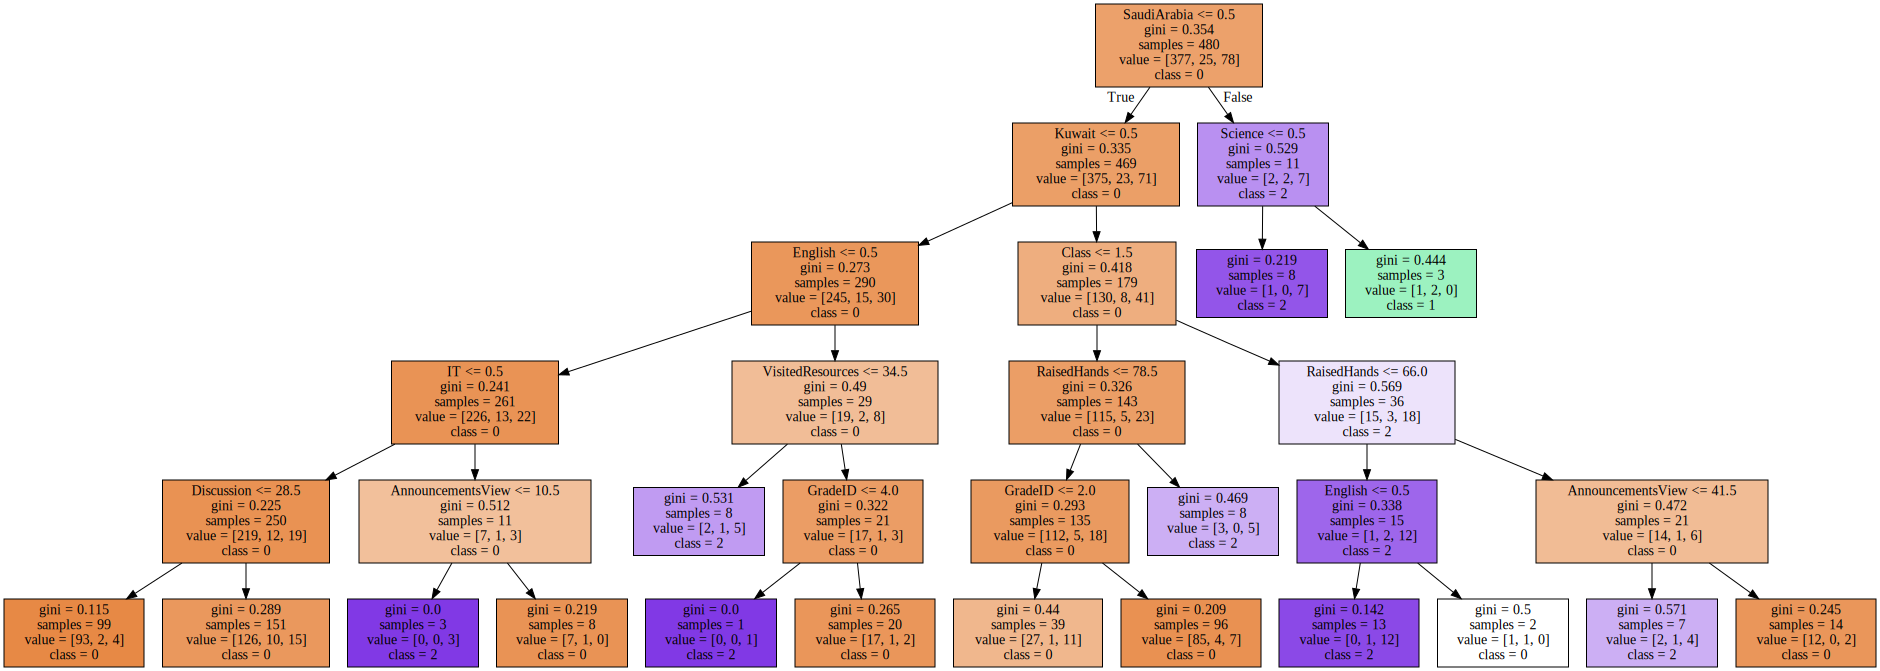

In [55]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

labels = dfml.columns.tolist()

graph = Source(export_graphviz(vola_smote_dt,
                               out_file=None,
                               feature_names=labels,
                               class_names=['0', '1', '2', '3'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

### Undersampling decision tree

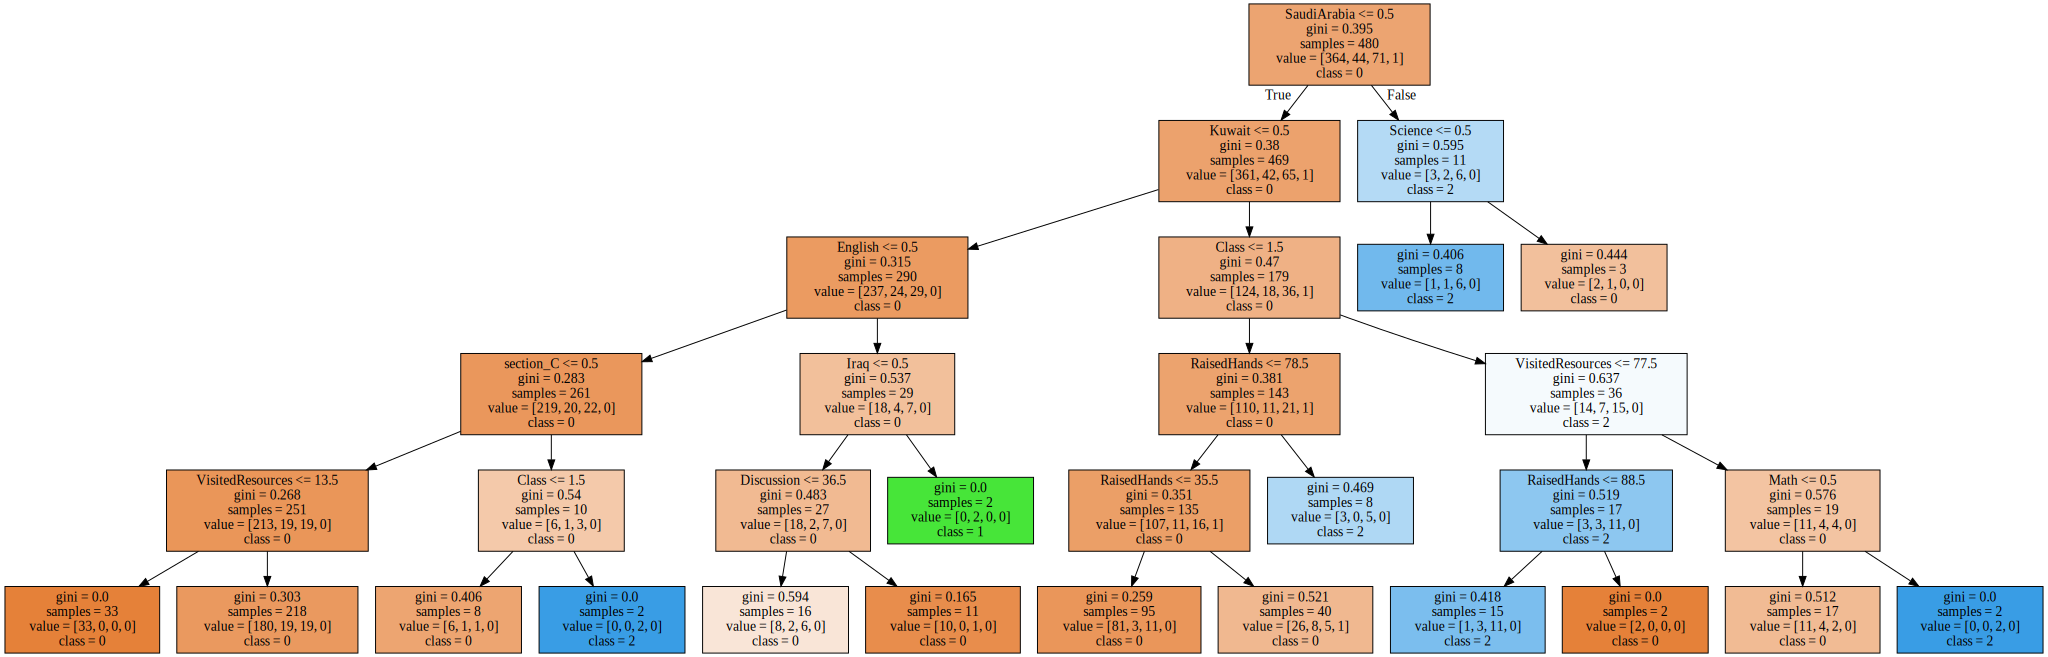

In [56]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

labels = dfml.columns.tolist()

graph = Source(export_graphviz(vola_under_dt,
                               out_file=None,
                               feature_names=labels,
                               class_names=['0', '1', '2', '3'],
                               filled = True))
display(SVG(graph.pipe(format='svg')))

In [57]:
export_graphviz(vola_smote_dt,
                impurity=False,
                filled=True,
                feature_names=labels,
                class_names=['0', '1', '2', '3'],
                out_file='../MRes/images/smoteDT.dot')

In [58]:
export_graphviz(vola_under_dt,
                impurity=False,
                filled=True,
                feature_names=labels,
                class_names=['0', '1', '2', '3'],
                out_file='../MRes/images/underDT.dot')

In [259]:
from sklearn.neighbors import LocalOutlierFactor

X = dfml.values
lof = LocalOutlierFactor()
y_pred = lof.fit_predict(X)
X_scores = lof.negative_outlier_factor_

In [260]:
df['lof_pred'] = y_pred

In [261]:
df['lof_pred'].value_counts()

 1    431
-1     49
Name: lof_pred, dtype: int64

In [262]:
df.to_csv('../Datasets/academic_interp_all_Class.csv', index=False)

# Plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("whitegrid")


df = pd.read_csv('../Datasets/academic_interp_all_Gender.csv', header=0)
df = df.replace({'Class': {'L': 'Low', 'M': 'Mid', 'H': 'High'}})

dfplus = pd.read_csv('../Datasets/academic_onehot_all_Gender.csv', header=0)
dfplus = dfplus.replace({'Class': {0: 'Low', 1: 'Mid', 2: 'High'},
                 'Relation': {0: 'Mother', 1: 'Father'},
                 'Gender': {0: 'Female', 1: 'Male'}})

dfplus['Label'] = dfplus.Class

zero = df.loc[df.cat_under == 0]
one = df.loc[df.cat_under == 1]
two = df.loc[df.cat_under == 2]


# Blue, purple, red colors
ncl2 = ["#336184", "#e1485d"]
ncl3 = ["#336184", "#8a5571", "#e1485d"]
ncl4 = ["#336184", "#8a5571", "#e1485d", "#3d998e"] 

# All blue colors
#ncl4 = ["#003a65", "#557c98", "#aabdcc", "#ffffff"]
#ncl3 = ["#003a65", "#557c98", "#aabdcc"]
#ncl2 = ["#003a65", "#557c98"]

nclTrue = ["#003A65", "#D91A35"]

sns.set_palette(sns.color_palette(ncl4))

c1 = sns.color_palette(ncl4)[0]
c2 = sns.color_palette(ncl4)[1]
c3 = sns.color_palette(ncl4)[2]
c4 = sns.color_palette(ncl4)[3]

rc1 = sns.color_palette(nclTrue)[0]
rc2 = sns.color_palette(nclTrue)[1]

In [2]:
list(df.columns.values)

['Gender',
 'Nationality',
 'StageID',
 'GradeID',
 'SectionID',
 'Topic',
 'Semester',
 'Relation',
 'RaisedHands',
 'VisitedResources',
 'AnnouncementsView',
 'Discussion',
 'ParentAnsweringSurvey',
 'ParentSchoolSatisfaction',
 'StudentAbsenceDays',
 'Class',
 'base',
 'smote',
 'under',
 'base_p',
 'smote_p',
 'under_p',
 'cat_smote',
 'cat_under',
 'abs_smote',
 'abs_under',
 'lof_pred']

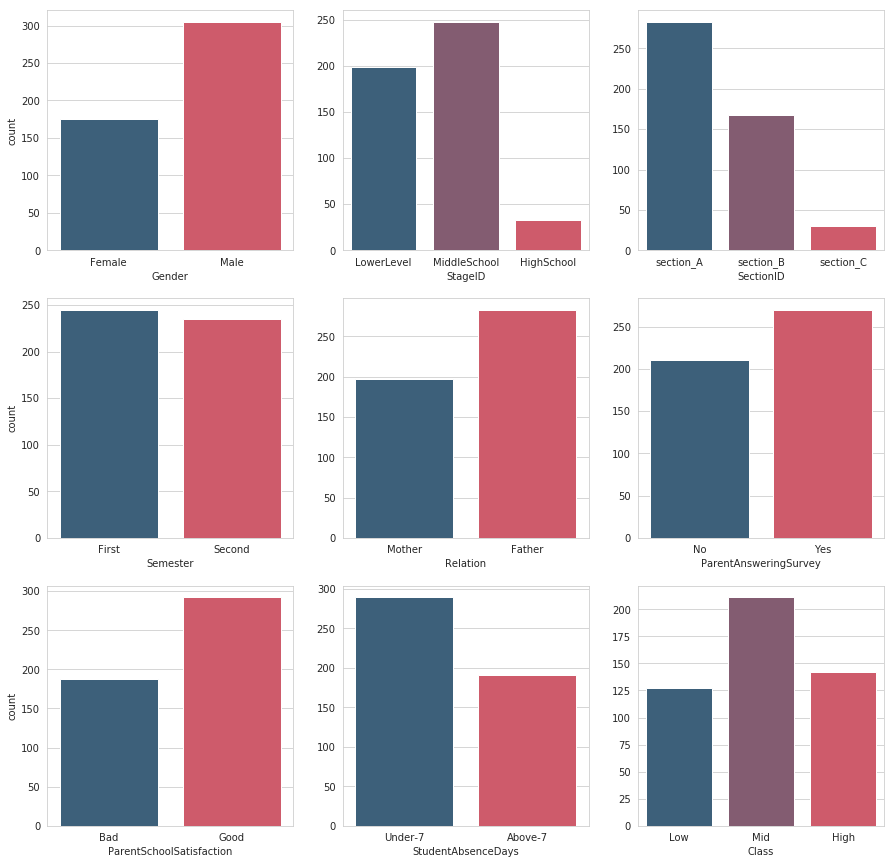

In [3]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Gender", data=df, order=['Female', 'Male'], ax=axes[0, 0])
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="StageID", data=df, ax=axes[0, 1])
axes[0, 1].set_ylabel('')
sns.countplot(x="SectionID", data=df, ax=axes[0, 2])
axes[0, 2].set_ylabel('')
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Semester", data=df, ax=axes[1, 0])
sns.countplot(x="Relation", data=df, order=['Mother', 'Father'], ax=axes[1, 1])
axes[1, 1].set_ylabel('')
sns.countplot(x="ParentAnsweringSurvey", data=df, order=['No', 'Yes'], ax=axes[1, 2])
axes[1, 2].set_ylabel('')
sns.countplot(x="ParentSchoolSatisfaction", data=df, order=['Bad', 'Good'], ax=axes[2, 0])
sns.countplot(x="StudentAbsenceDays", data=df, ax=axes[2, 1])
axes[2, 1].set_ylabel('')
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="Class", data=df, order=['Low', 'Mid', 'High'], ax=axes[2, 2])
axes[2, 2].set_ylabel('')

plt.savefig('../MRes/images/histograms.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

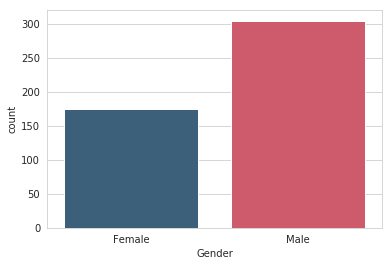

In [4]:
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x='Gender', data=df, order=['Female', 'Male'])
plt.savefig('../MRes/images/genderCount.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

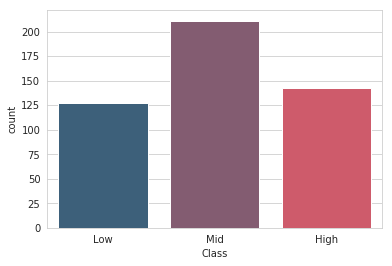

In [5]:
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x='Class', data=df, order=['Low', 'Mid', 'High'])
plt.savefig('../MRes/images/classCount.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

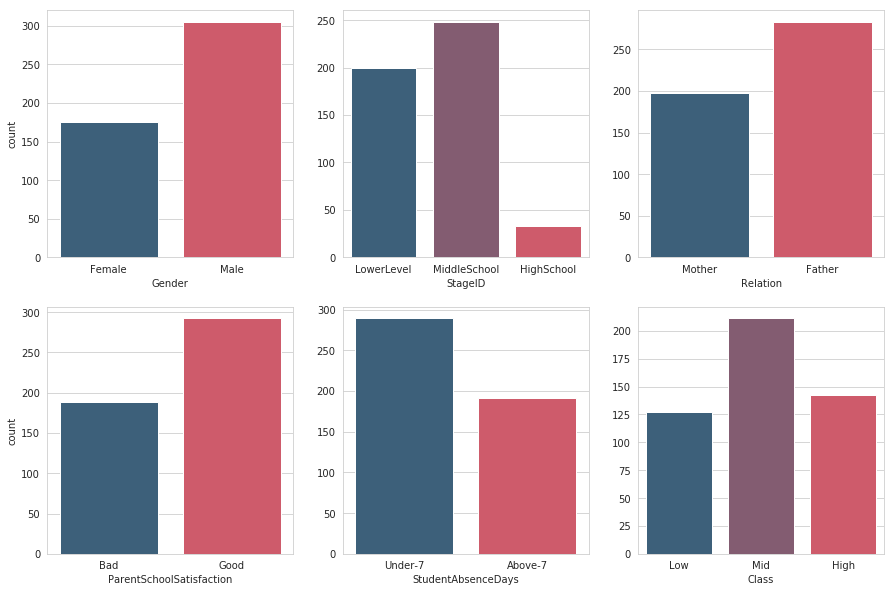

In [6]:
f, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Gender", data=df, order=['Female', 'Male'], ax=axes[0, 0])
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="StageID", data=df, ax=axes[0, 1])
axes[0, 1].set_ylabel('')
sns.set_palette(sns.color_palette(ncl2))
sns.countplot(x="Relation", data=df, order=['Mother', 'Father'], ax=axes[0, 2])
axes[0, 2].set_ylabel('')
sns.countplot(x="ParentSchoolSatisfaction", data=df, order=['Bad', 'Good'], ax=axes[1, 0])
sns.countplot(x="StudentAbsenceDays", data=df, ax=axes[1, 1])
axes[1, 1].set_ylabel('')
sns.set_palette(sns.color_palette(ncl3))
sns.countplot(x="Class", data=df, order=['Low', 'Mid', 'High'], ax=axes[1, 2])
axes[1, 2].set_ylabel('')

plt.savefig('../MRes/images/presCounts.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

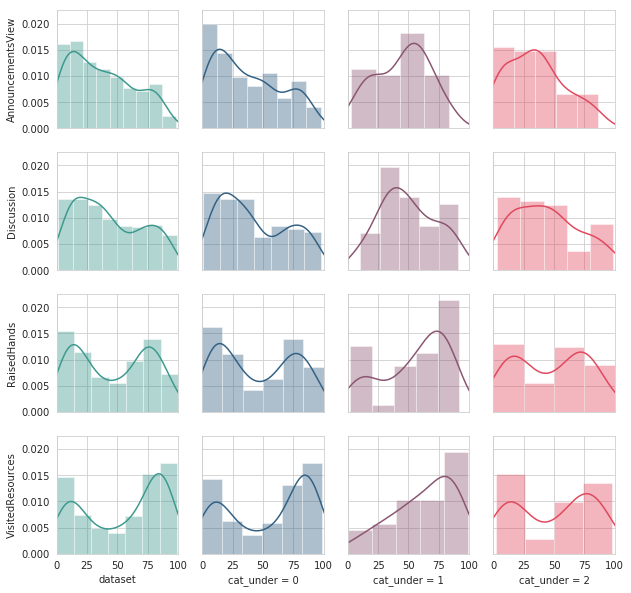

In [7]:
f, axes = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)

sns.distplot(df["AnnouncementsView"], ax=axes[0, 0], color=c4, axlabel='')
axes[0, 0].set_ylabel('AnnouncementsView')
sns.distplot(zero["AnnouncementsView"], ax=axes[0, 1], color=c1, axlabel='')
sns.distplot(one["AnnouncementsView"], ax=axes[0, 2], color=c2, axlabel='')
sns.distplot(two["AnnouncementsView"], ax=axes[0, 3], color=c3, axlabel='')

sns.distplot(df["Discussion"], ax=axes[1, 0], color=c4, axlabel='')
axes[1, 0].set_ylabel('Discussion')
sns.distplot(zero["Discussion"], ax=axes[1, 1], color=c1, axlabel='')
sns.distplot(one["Discussion"], ax=axes[1, 2], color=c2, axlabel='')
sns.distplot(two["Discussion"], ax=axes[1, 3], color=c3, axlabel='')

sns.distplot(df["RaisedHands"], ax=axes[2, 0], color=c4, axlabel='')
axes[2, 0].set_ylabel('RaisedHands')
sns.distplot(zero["RaisedHands"], ax=axes[2, 1], color=c1, axlabel='')
sns.distplot(one["RaisedHands"], ax=axes[2, 2], color=c2, axlabel='')
sns.distplot(two["RaisedHands"], ax=axes[2, 3], color=c3, axlabel='')

sns.distplot(df["VisitedResources"], ax=axes[3, 0], color=c4, axlabel='dataset')
axes[3, 0].set_ylabel('VisitedResources')
sns.distplot(zero["VisitedResources"], ax=axes[3, 1], color=c1, axlabel='cat_under = 0')
sns.distplot(one["VisitedResources"], ax=axes[3, 2], color=c2, axlabel='cat_under = 1')
sns.distplot(two["VisitedResources"], ax=axes[3, 3], color=c3, axlabel='cat_under = 2')

plt.xlim(0,100)
#plt.savefig('../MRes/images/catHist.pdf',
#            bbox_inches="tight", pad_inches=0)
plt.show()

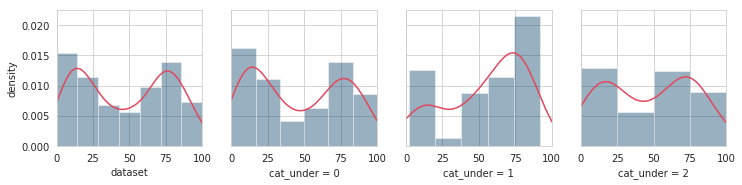

In [8]:
f, axes = plt.subplots(ncols=4, figsize=(12, 2.5), sharex=True, sharey=True)

sns.distplot(df["RaisedHands"], ax=axes[0], color=rc1, axlabel='dataset', kde_kws={"color": c3})
axes[0].set_ylabel('density')
sns.distplot(zero["RaisedHands"], ax=axes[1], color=rc1, axlabel='cat_under = 0', kde_kws={"color": c3})
sns.distplot(one["RaisedHands"], ax=axes[2], color=rc1, axlabel='cat_under = 1', kde_kws={"color": c3})
sns.distplot(two["RaisedHands"], ax=axes[3], color=rc1, axlabel='cat_under = 2', kde_kws={"color": c3})

plt.xlim(0,100)
plt.savefig('../MRes/images/raisedHist.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

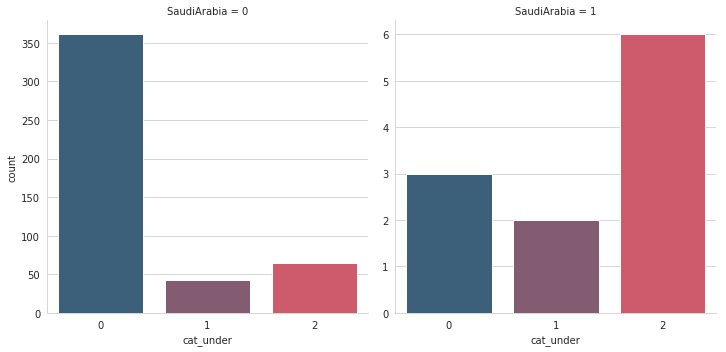

In [9]:
sns.set_palette(sns.color_palette(ncl3))
sns.catplot(data=dfplus[dfplus.cat_under < 3], x="cat_under", col="SaudiArabia", kind="count",
            sharey=False)
#plt.savefig('../MRes/images/saudiCat.pdf',
#            bbox_inches="tight", pad_inches=0)
plt.show()

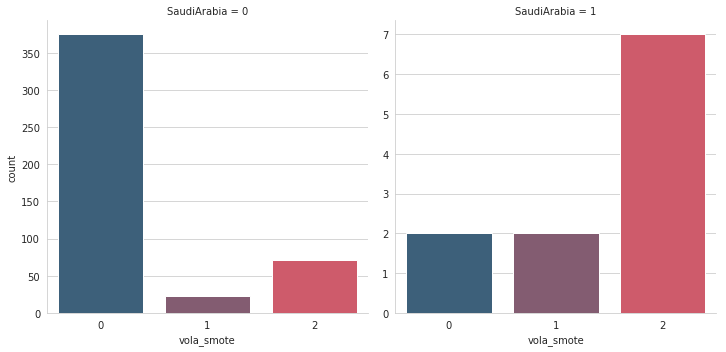

In [21]:
dfplus = dfplus.rename({'cat_smote': 'vola_smote', 'cat_under': 'vola_under'}, axis='columns')
sns.set_palette(sns.color_palette(ncl3))
sns.catplot(data=dfplus[dfplus.vola_smote < 3], x="vola_smote", col="SaudiArabia", kind="count",
            sharey=False)
plt.savefig('../Submission/images/saudiCat.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

In [14]:
dfpluss.Label.value_counts()

1.0     445
2.0     260
0.0     255
Mid     211
High    142
Low     127
Name: Label, dtype: int64

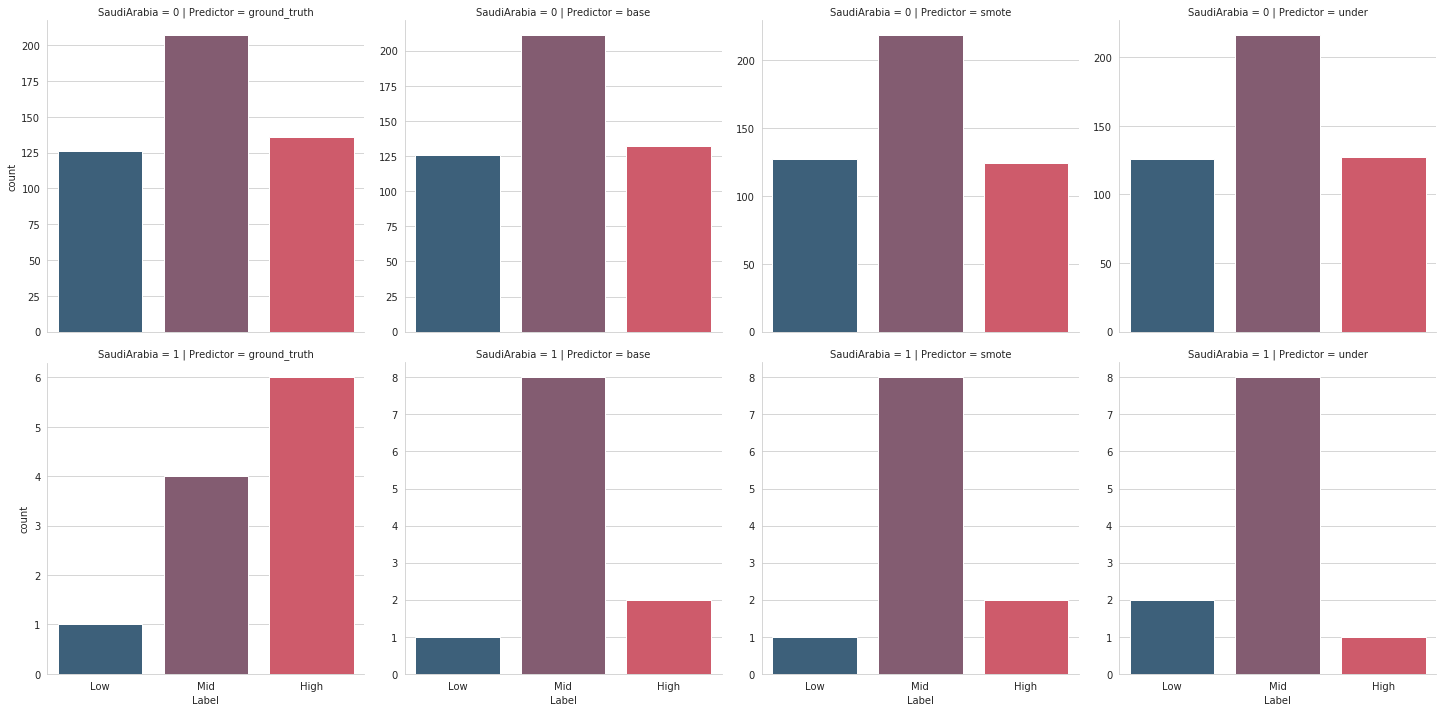

In [10]:
dfp = dfplus.rename({'Class': 'ground_truth'}, axis='columns')
dfp['Change'] = ['Better' if dfp.smote[i] > dfp.base[i]
                 else 'Same' if dfp.smote[i] == dfp.base[i]
                 else 'Worse' for i in range(dfp.shape[0])]
dfpluss = pd.melt(dfp, id_vars=['SaudiArabia', 'Change'], value_vars=['base', 'smote', 'under', 'ground_truth'],
                  var_name='Predictor', value_name='Label')
dfpluss.Label = dfpluss.Label.replace({0: 'Low', 1: 'Mid', 2: 'High'})

sns.set_palette(sns.color_palette(ncl3))
g = sns.catplot(data=dfpluss, row='SaudiArabia', x='Label', col='Predictor',
                kind='count', sharey=False, order=['Low', 'Mid', 'High'],
                col_order=['ground_truth', 'base', 'smote', 'under'])

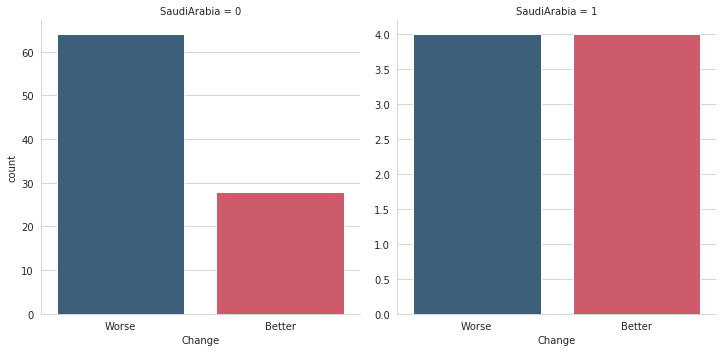

In [12]:
sns.set_palette(sns.color_palette(ncl2))
g = sns.catplot(data=dfpluss[dfpluss.Change != 'Same'], col='SaudiArabia',
                x='Change', kind='count', sharey=False)
plt.savefig('../Submission/images/saudiChange.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

as expected, volatility is very different in saudi as compared to the rest

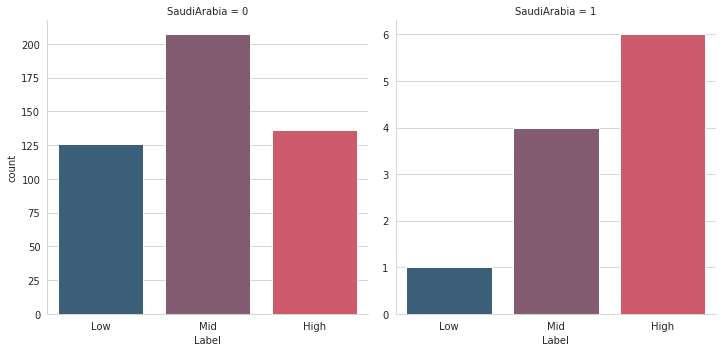

In [22]:
sns.catplot(data=dfplus, x="Label", col="SaudiArabia", kind="count",
            sharey=False, order=['Low', 'Mid', 'High'])
plt.savefig('../Submission/images/saudiClass.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

Saudi also has very different distribution of classes, with most of their student being class 2!

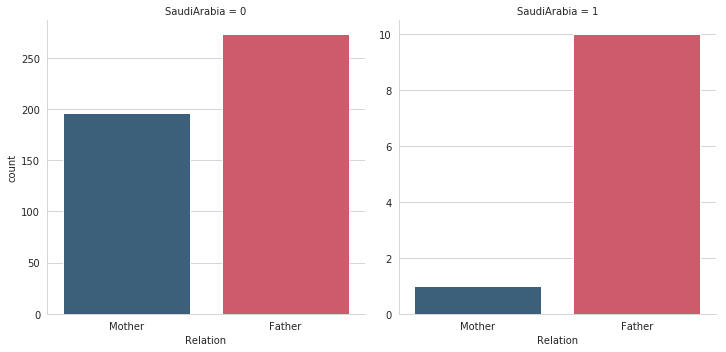

In [72]:
sns.set_palette(sns.color_palette(ncl2))
sns.catplot(data=dfplus, x="Relation", col="SaudiArabia", kind="count",
            sharey=False, order=['Mother', 'Father'])
plt.savefig('../MRes/images/saudiRelation.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

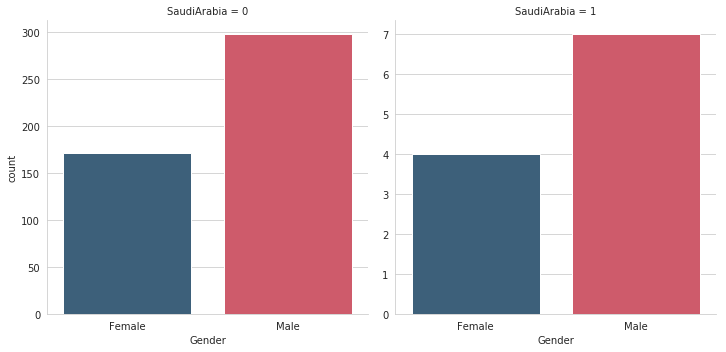

In [73]:
sns.catplot(data=dfplus, x="Gender", col="SaudiArabia", kind="count",
            sharey=False, order=['Female', 'Male'])
plt.savefig('../MRes/images/saudiGender.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

In [74]:
df3 = df[['Class',
          'AnnouncementsView',
          'Discussion',
          'RaisedHands',
          'VisitedResources']]

df3 = pd.melt(df3,
              id_vars=['Class'],
              value_vars=['AnnouncementsView', 'Discussion', 'RaisedHands', 'VisitedResources'])

df3 = df3.rename(index=str, columns={"value": "count"})

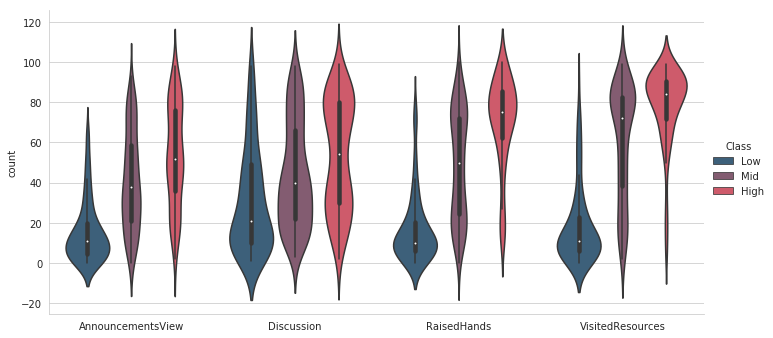

In [75]:
sns.set_palette(sns.color_palette(ncl3))
ax = sns.catplot(x="variable", y="count", hue="Class",
            kind="violin", data=df3, aspect=2, hue_order=['Low', 'Mid', 'High'])
ax.set(xlabel='')

plt.savefig('../MRes/images/classViolin.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

Violin plots show how classes have very different distributions along numerical variables, mention right/left skewed

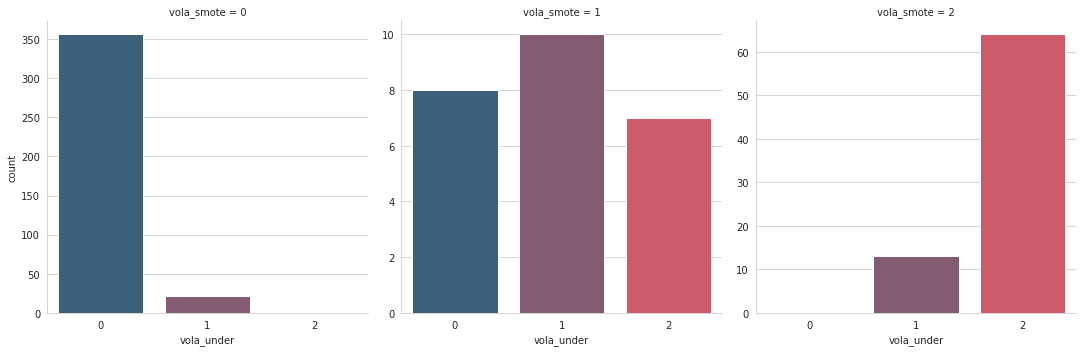

In [14]:
sns.set_palette(sns.color_palette(ncl3))
df = df.rename({'cat_smote': 'vola_smote', 'cat_under': 'vola_under'}, axis='columns')
sns.catplot(data=df[df.vola_under < 3], x="vola_under", col="vola_smote", kind="count", sharey=False)
plt.savefig('../Submission/images/catUnder.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

small discrepancies in under vs smote volatilities

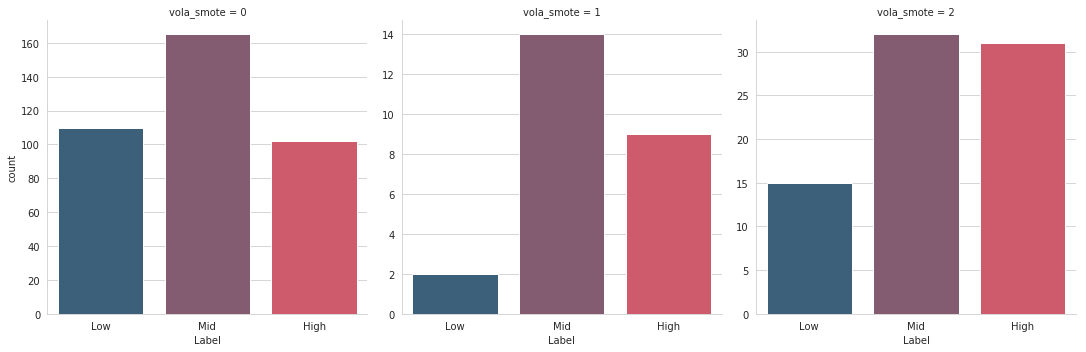

In [26]:
df = df.rename({'Class': 'Label'}, axis='columns')
sns.set_palette(sns.color_palette(ncl3))
sns.catplot(data=df, x="Label", col="vola_smote", kind="count", sharey=False, order=['Low', 'Mid', 'High'])
plt.savefig('../Submission/images/catClass.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

The ratio between Class 0 & Class 2 changes when moving away from vola 0 to vola 2. Class 2 is much more likely in vola=2

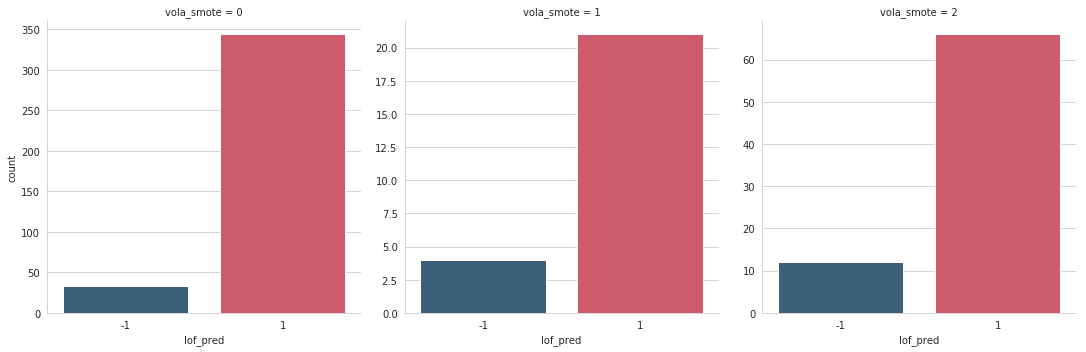

In [16]:
sns.set_palette(sns.color_palette(ncl2))
sns.catplot(data=df, x="lof_pred", col="vola_smote", kind="count", sharey=False)
plt.savefig('../Submission/images/catLOF.pdf',
            bbox_inches="tight", pad_inches=0)
plt.show()

very small discrepancies with lof_pred per volatility. If anything, a little bit more outliers on the 2 category

## Contingency tables / Chi-sq test for check correlation between lof and cat. volatility

In [80]:
pd.crosstab(df['cat_smote'],
            df['lof_pred'],
            rownames=['cat_smote'],
            colnames=['lof_pred'],
            normalize='index').round(2)

lof_pred,-1,1
cat_smote,,
0,0.09,0.91
1,0.16,0.84
2,0.15,0.85


In [81]:
pd.crosstab(df['cat_smote'],
            df['Class'],
            rownames=['cat_smote'],
            colnames=['Class'],
            normalize='index').round(2)

Class,High,Low,Mid
cat_smote,,,
0,0.27,0.29,0.44
1,0.36,0.08,0.56
2,0.40,0.19,0.41


## Confusion matrices for Class

In [268]:
df = pd.read_csv('../Datasets/academic_interp_all_Class.csv', header=0)

In [269]:
pd.crosstab(df.Class, df.under)

under,0.0,1.0,2.0
Class,,,
H,0,5,137
L,126,1,0
M,14,178,19


In [83]:
pd.crosstab(dfplus.loc[dfplus.SaudiArabia == 1].Class, dfplus.loc[dfplus.SaudiArabia == 1].base, normalize='index').round(2)

base,0.0,1.0,2.0
Class,,,
High,0.00,0.83,0.17
Low,0.00,1.00,0.00
Mid,0.25,0.50,0.25


In [84]:
pd.crosstab(dfplus.loc[dfplus.SaudiArabia == 1].Class, dfplus.loc[dfplus.SaudiArabia == 1].smote, normalize='index').round(2)

smote,0.0,1.0,2.0
Class,,,
High,0.00,0.83,0.17
Low,0.00,1.00,0.00
Mid,0.25,0.50,0.25


In [85]:
pd.crosstab(dfplus.loc[dfplus.SaudiArabia == 1].Class, dfplus.loc[dfplus.SaudiArabia == 1].under, normalize='index').round(2)

under,0.0,1.0,2.0
Class,,,
High,0.00,0.83,0.17
Low,1.00,0.00,0.00
Mid,0.25,0.75,0.00


In [87]:
pd.crosstab(df.loc[df.Gender == 'Male'].Class, df.loc[df.Gender == 'Male'].base)

base,0.0,1.0,2.0
Class,,,
High,0,22,45
Low,90,12,1
Mid,10,115,10


In [8]:
pd.crosstab(df.loc[df.Gender == 'Female'].Class, df.loc[df.Gender == 'Female'].base, normalize='index').round(2)

base,0.0,1.0,2.0
Class,,,
High,0.00,0.16,0.84
Low,0.88,0.12,0.00
Mid,0.08,0.72,0.20


In [9]:
pd.crosstab(df.loc[df.Gender == 'Female'].Class, df.loc[df.Gender == 'Female'].smote, normalize='index').round(2)

smote,0.0,1.0,2.0
Class,,,
High,0.00,0.16,0.84
Low,0.83,0.17,0.00
Mid,0.07,0.80,0.13


In [10]:
pd.crosstab(df.loc[df.Gender == 'Female'].Class, df.loc[df.Gender == 'Female'].under, normalize='index').round(2)

under,0.0,1.0,2.0
Class,,,
High,0.00,0.17,0.83
Low,0.88,0.12,0.00
Mid,0.08,0.76,0.16


In [92]:
pd.crosstab(df['lof_pred'],
            df['cat_under'],
            rownames=['lof_pred'],
            colnames=['cat_under'])

cat_under,0,1,2,3
lof_pred,,,,
-1,33,6,10,0
1,331,38,61,1


In [93]:
pd.crosstab(df['cat_smote'],
            df['cat_under'],
            colnames=['cat_under'],
            rownames=['cat_smote'],
            normalize='index').round(2)

cat_under,0,1,2,3
cat_smote,,,,
0,0.94,0.06,0.00,0.00
1,0.32,0.40,0.28,0.00
2,0.00,0.17,0.82,0.01


In [257]:
from scipy.stats import chi2_contingency

df = pd.read_csv('../Datasets/academic_interp_all_Class.csv', header=0)

chi2_contingency(pd.crosstab(df['cat_smote'], df['cat_under']))

(379.82116332581086,
 6.074691822220556e-79,
 6,
 array([[2.906250e+02, 6.277500e+01, 1.860000e+01],
        [2.109375e+01, 4.556250e+00, 1.350000e+00],
        [6.250000e+01, 1.350000e+01, 4.000000e+00],
        [7.812500e-01, 1.687500e-01, 5.000000e-02]]))

In [263]:
chi2_contingency(pd.crosstab(df['cat_smote'], df['lof_pred']))

(5.198763585967281,
 0.1578080142462742,
 3,
 array([[3.79750000e+01, 3.34025000e+02],
        [2.75625000e+00, 2.42437500e+01],
        [8.16666667e+00, 7.18333333e+01],
        [1.02083333e-01, 8.97916667e-01]]))

In [264]:
chi2_contingency(pd.crosstab(df['cat_smote'], df['Class']))

(10.976893223631953,
 0.08909320584976321,
 6,
 array([[110.05      ,  98.425     , 163.525     ],
        [  7.9875    ,   7.14375   ,  11.86875   ],
        [ 23.66666667,  21.16666667,  35.16666667],
        [  0.29583333,   0.26458333,   0.43958333]]))

In [265]:
chi2_contingency(pd.crosstab(df['cat_smote'], df['Gender']))

(0.6196771675354436,
 0.8919133287258458,
 3,
 array([[135.625     , 236.375     ],
        [  9.84375   ,  17.15625   ],
        [ 29.16666667,  50.83333333],
        [  0.36458333,   0.63541667]]))

## Compare between balancings

In [34]:
dfg = pd.read_csv('../Datasets/academic_interp_all_Gender.csv',
                  header=0)
dfc = pd.read_csv('../Datasets/academic_interp_all_Class.csv',
                  header=0)

In [44]:
dfg.cat_smote.value_counts(normalize=True).round(2)

0    0.79
2    0.16
1    0.05
Name: cat_smote, dtype: float64

In [45]:
dfg.cat_under.value_counts(normalize=True).round(2)

0    0.76
2    0.15
1    0.09
3    0.00
Name: cat_under, dtype: float64

In [49]:
dfc.cat_smote.value_counts(normalize=True).round(2)

0    0.78
2    0.17
1    0.06
3    0.00
Name: cat_smote, dtype: float64

In [47]:
dfc.cat_under.value_counts(normalize=True).round(2)

0    0.78
1    0.17
2    0.05
Name: cat_under, dtype: float64